In [3]:
#Import Statements
import pandas as pd
import numpy as np
from sklearn.metrics import  silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist

In [5]:
#Loading the dataset
dataset = pd.read_csv('./Image_Test_file.txt', header= None)

In [6]:
dataset.shape

(10000, 784)

In [7]:
#Checking if there are any null values in the dataset
null_count=dataset.isnull().sum()
null_count.describe()

count    784.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

In [8]:
#Removing the colums which contain only zeros
non_zero_dataset = dataset.loc[:, (dataset != 0).any(axis=0)]

In [9]:
non_zero_dataset


,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,88,89,90,91,...,723,724,725,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,158,254,123,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,87,251,252,128,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
#Scaling the dataset and converting it into an n-dimensional numpy array.
np_dataset = (non_zero_dataset.to_numpy(copy= True))/255

In [11]:
#time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
decomposed_data = tsne.fit_transform(np_dataset)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.911s...
[t-SNE] Computed neighbors for 10000 samples in 151.992s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.030843
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.762299
[t-SNE] KL divergence after 300 iterations: 2.986586


In [12]:
decomposed_data

array([[-0.07782286, -2.6039124 ],
       [ 4.143915  , 10.033555  ],
       [-2.0259573 , -7.353654  ],
       ...,
       [-3.5000439 , -7.024985  ],
       [-0.940207  , -5.3454823 ],
       [ 4.991713  ,  1.8065786 ]], dtype=float32)

In [13]:
'''
Cluster Assignment Fuction
Parameters: 
        data : n-dimensional Numpy array
        Centroids : K-dimensional Numpy array 
        K: Default value is 3, splits the data in to k clusters
Returns the cluster assignment of each row

In this fuction for each row we calculate its distance from each of the centroids and assign it to the centroid which it is closest to
To calculate the distance i've used np.linalg.norm (which is same as Euclidian distance)  
'''
def Cluster_Assignment(data, centroids, k =2):
  cluster_assignments = np.empty(len(dataset))
  for i in range(len(data)):
    min_distance = np.Inf
    for cluster in range(k):
      distance = np.linalg.norm(data[i]-centroids[cluster])
      if distance < min_distance:
        min_distance = distance
        cluster_assignments[i] = cluster
  return cluster_assignments

In [14]:
'''
Move_Centroid Function:
  Parameters: 
        data : n-dimensional Numpy array
        Centroids : K-dimensional Numpy array 
        K: Default value is 3, splits the data in to k clusters
        Attributes: Number of Features in the dataset
        Instances: # rows in the dataset
        cluster_assignments : The current cluster assignment of each data point in the dataset.
  Take the average of the all datapoints in the cluster. This average will be new centroids.
  Returns the previous centroids and the current centroids      
'''
def Move_Centroid(centroids, k, attributes, instances, cluster_assignments, data):
  previous_centroids = centroids.copy()
  #current_centroids = np.empty(initial_centroids.shape)
  for cluster in range(k):
    for column in range(attributes):
      sum = 0.0
      count = 0.0
      average =None
      for row in range(instances):
        if(cluster == cluster_assignments[row]):
          sum += data[row, column]
          count+=1
          if count >0:
            average = sum/ count
        centroids[cluster, column] = average
  return previous_centroids, centroids

In [15]:
def Recursive_step(decomposed_data, k):  
  initial_centroids = decomposed_data[np.random.choice(decomposed_data.shape[0], size = k, replace= False)]
  attributes = decomposed_data.shape[1]
  instances = len(dataset)
  centroids_the_same = False
  current_centroids = np.empty(initial_centroids.shape)
  previous_centroids = initial_centroids
  Initial_cluster_assignments = Cluster_Assignment(decomposed_data, initial_centroids,k)
  previous_cluster_assignment = Initial_cluster_assignments
  new_cluster_assignment = np.empty(Initial_cluster_assignments.shape)
  max_iterations = 50
  scores =[]
  score = 0.0
  while max_iterations > 0 and (not(centroids_the_same)):
    previous_centroids, current_centroids = Move_Centroid(initial_centroids,k,attributes, instances,Initial_cluster_assignments, decomposed_data)
    centroids_the_same = (np.array_equal(previous_centroids,current_centroids) and score > 0.035)
    new_cluster_assignment=Cluster_Assignment(decomposed_data, current_centroids, k)
    score = silhouette_score(decomposed_data, new_cluster_assignment)
    previous_cluster_assignment = new_cluster_assignment
    max_iterations -=1
  print(new_cluster_assignment)
  return new_cluster_assignment

In [16]:
new_cluster_assignment = Recursive_step(decomposed_data, k=17)

[15.  5. 11. ... 11. 15.  4.]


In [17]:
a_file = open("output_tsne.txt", "w")
for label in new_cluster_assignment:
    # np.savetxt(a_file, row)
    a_file.write(str(int(label))+"\n")

a_file.close()

In [26]:
def visualize(decomposed_data, k, new_cluster_assignment):
  df_subset = pd.DataFrame()
  df_subset['tsne-2d-one'] = decomposed_data[:,0]
  df_subset['tsne-2d-two'] = decomposed_data[:,1]
  df_subset['clusters'] = new_cluster_assignment
  plt.figure(figsize=(10,8))
  sns.scatterplot(
      x="tsne-2d-one", y="tsne-2d-two",
      hue= df_subset['clusters'],
      palette=sns.color_palette('hls', as_cmap=True),
      data=df_subset,
      legend="full",
      alpha=0.3
  )

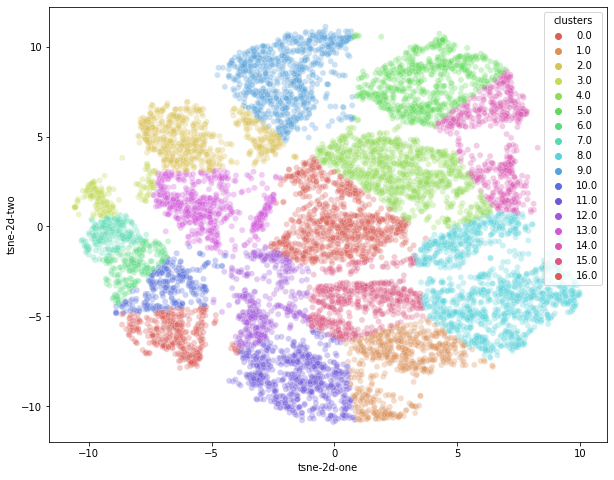

In [27]:
visualize(decomposed_data, 17, new_cluster_assignment)